In [16]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

finwiz_url = 'https://finviz.com/quote.ashx?t='

In [17]:
news_tables = {}
tickers = ['AAPL', 'AMZN', 'TSLA', 'GOOG', 'MSFT']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

In [18]:
# Read one single day of headlines for 'AMZN' 
amzn = news_tables['AMZN']
# Get all the table rows tagged in HTML with <tr> into 'amzn_tr'
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text' 
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 3:
        break

[video]Walmart's Amazon Prime Rival Doesn't Look Like Much of One
Jul-08-20 06:30AM  
Got $5,000? Buy Stocks in These 5 Industries Now
05:51AM  
France to Protect Economy; Violence in Serbia: Virus Update
05:44AM  
Amazon India's unit gets $308 million in fresh funds from parent
03:26AM  


In [19]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
parsed_news

[['AAPL',
  'Jul-08-20',
  '06:15AM',
  'Signal Tops Hong Kong Downloads After Fears of China Law Deepen'],
 ['AAPL',
  'Jul-08-20',
  '05:44AM',
  'France to Protect Economy; Violence in Serbia: Virus Update'],
 ['AAPL',
  'Jul-08-20',
  '03:03AM',
  'Tokyo shares track Wall Street lower as COVID-19 cases spike'],
 ['AAPL',
  'Jul-08-20',
  '03:03AM',
  'Big Techs China Face-Off Presages an Exodus From Hong Kong'],
 ['AAPL',
  'Jul-07-20',
  '11:47PM',
  'Japanese shares track Wall Street lower as coronavirus cases mount'],
 ['AAPL',
  'Jul-07-20',
  '08:32PM',
  "Japan Display shares tumble 6% after media report on Apple's full shift to OLED"],
 ['AAPL',
  'Jul-07-20',
  '07:27PM',
  'Three iPhone Suppliers That Will Benefit From the New Design'],
 ['AAPL', 'Jul-07-20', '06:02PM', 'Is FMAANG Overrated?'],
 ['AAPL',
  'Jul-07-20',
  '05:45PM',
  'Apple (AAPL) Stock Moves -0.31%: What You Should Know'],
 ['AAPL',
  'Jul-07-20',
  '05:35PM',
  'Diversify? Almost half of Warren Buffetts 

In [20]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,AAPL,2020-07-08,06:15AM,Signal Tops Hong Kong Downloads After Fears of...,0.185,0.596,0.219,0.1280
1,AAPL,2020-07-08,05:44AM,France to Protect Economy; Violence in Serbia:...,0.299,0.511,0.190,-0.3612
2,AAPL,2020-07-08,03:03AM,Tokyo shares track Wall Street lower as COVID-...,0.177,0.645,0.177,0.0000
3,AAPL,2020-07-08,03:03AM,Big Techs China Face-Off Presages an Exodus Fr...,0.000,1.000,0.000,0.0000
4,AAPL,2020-07-07,11:47PM,Japanese shares track Wall Street lower as cor...,0.177,0.645,0.177,0.0000


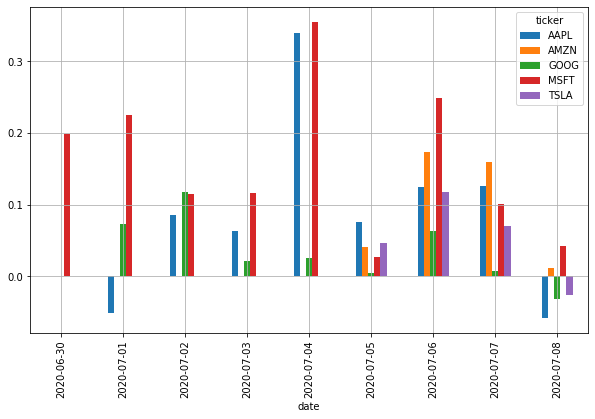

In [21]:
plt.rcParams['figure.figsize'] = [10, 6]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()

In [15]:
mean_scores

ticker,AAPL,AMZN,GOOG,MSFT,TSLA
date,,,,,
2020-06-30,NaN,NaN,NaN,0.199050,NaN
2020-07-01,-0.051350,NaN,0.051831,0.225438,NaN
2020-07-02,0.085494,NaN,0.117793,0.115117,NaN
2020-07-03,0.062860,NaN,0.021767,0.116187,NaN
2020-07-04,0.339500,NaN,0.025800,0.355267,NaN
2020-07-05,0.075963,0.090800,0.005160,0.026700,-0.144400
2020-07-06,0.124976,0.172998,0.063294,0.249300,0.117166
2020-07-07,0.125559,0.159353,0.008036,0.101037,0.068179
2020-07-08,-0.090300,0.043650,-0.146783,0.000000,-0.106067
